In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

from itertools import product

In [172]:
DATASET = 'Walmart'

# column explanations
# time_idx is the first time index of the forecast, i.e. the first date for which i need a forecast
# h is the forecast horizon
# pred_idx is the time index of the forecasted, date, so it is time_idx + h - 1; a one day ahead has h=1 and pred_idx = time_idx
# pred is the predicted value
# model is the model used for forecasting, we have ['hnamc', 'tft', 'prophet', 'ets', 'arima']
# true is the actual value
# q is the quantile but we are only working with 0.5 quantile for now, or mean predictions (which is is not necessarily the 0.5 quantile ;) )
# pred_date is the date of the predicted date, mapping to pred_idx
# art is the article id
# pos the is the store id


models = [model.split('.')[0] for model in os.listdir(f'{DATASET}') if model.endswith('.pkl')]
models = ['hnam','tft', 'prophet','sarimax','ets']

data = pd.DataFrame()
for model in models:
    data_temp = pd.read_pickle(f'{DATASET}/{model}.pkl')
    data_temp['model'] = model
    data_temp = data_temp.rename(columns={'u_id':'time_series'})
    data = pd.concat([data, data_temp], axis=0)
data['art'] = data['time_series'].str.split('_').str[0]
data['pos'] = data['time_series'].str.split('_').str[1]
data['pred'] = np.maximum(data['pred'],0)
data = data.rename(columns={'y_hat':'pred'})


actuals = pd.read_pickle(f'../Processed/{DATASET}/{DATASET}_data.pkl')
data = data[['time_idx', 'time_series','h','pred_idx', 'pred', 'model']]

data = data.merge(actuals,left_on=['time_series','pred_idx'],right_on=['time_series','time_idx'],how='left')
data = data.drop(['time_idx_y'],axis=1).rename(columns={'time_idx_x':'time_idx'})
data = data.dropna()

proph_idx = set(data[data.model=='prophet']['time_idx'].unique())
hnamc_idx = set(data[data.model=='hnam']['time_idx'].unique())
valid_idx = proph_idx.intersection(hnamc_idx)
data = data[data.time_idx.isin(valid_idx)]

proph_idx = set(data[data.model=='prophet']['pred_idx'].unique())
hnamc_idx = set(data[data.model=='hnam']['pred_idx'].unique())
valid_idx = proph_idx.intersection(hnamc_idx)
data = data[data.pred_idx.isin(valid_idx)]

# calculate error scores
data['smape'] = 2 * np.abs(data['sales'] - data['pred']) / (np.abs(data['sales']) + np.abs(data['pred']))
data['mape'] = np.abs(data['sales'] - data['pred']) / np.abs(data['sales'])
data['mae'] = np.abs(data['sales'] - data['pred'])
data['rmse'] = (data['sales'] - data['pred']) ** 2
# scale mae and rmse by std of sales per time_series
data['mae_std'] = data['mae'] / data.groupby('time_series')['sales'].transform('std')
data['rmse_std'] = data['rmse'] / data.groupby('time_series')['sales'].transform('std')
display(data.groupby('model').nunique()[['time_idx','pred_idx','date','time_series']])

error_metrics = ['smape','mae_std','rmse_std']
rmse_ranks = data.groupby(['model','time_series'])[error_metrics].mean().unstack().rank(axis=0)['rmse_std'].melt(ignore_index=False).groupby(['model','value']).count().unstack().fillna(0)
rmse_ranks /= data['time_series'].nunique()
rmse_ranks = rmse_ranks.round(3)
rmse_ranks = rmse_ranks.applymap(lambda x: f'{x:.1%}')
rmse_ranks = rmse_ranks.loc[models]
rmse_ranks.index = [model.upper() for model in rmse_ranks.index]
rmse_ranks.columns = range(1,6)
rmse_ranks.columns.name = 'Rank'
ranks12 = rmse_ranks[[1,2]]
ranks12.columns = ['1\\textsuperscript{st}','2\\textsuperscript{nd}']
# Calculate median error scores for each model



# model_performance = data[data.pred_idx < new_trains[0]].groupby('model')[error_metrics].agg(['mean','median'])
model_performance = data.groupby('model')[error_metrics].agg(['mean','median'])
model_performance.columns = pd.MultiIndex.from_tuples(list(product(['SMAPE','Std. MAE','Std. RMSE'],['$\\bar{x}$','$\tilde{x}$'])))
model_performance = model_performance.loc[models]
model_performance.index = [model.upper() for model in model_performance.index]
model_performance = model_performance.round(3)
model_performance[[('Rank Freq.',ranks12.columns[0]),('',ranks12.columns[1])]] = ranks12


def custom_format(x):
    if isinstance(x, float):
        if abs(x) >= 1e2:  # Scientific notation threshold
            return f'{x:.1e}'  # Scientific notation with 1 decimal place
        else:
            return f'{x:.3f}'  # Regular formatting with 3 decimal places
    return x
# Apply the custom formatting to the DataFrame
formatted_model_performance = model_performance.applymap(custom_format)

# Display the DataFrame (optional)
display(formatted_model_performance)

# Convert the formatted DataFrame to LaTeX
latex_string = formatted_model_performance.to_latex(
    caption=f'Mean and median error metrics in {DATASET.capitalize()}',
    label=f'tab:metrics_median_{DATASET.lower()}',
    position='h',
    column_format='rcccccccc',
    formatters={
        ('SMAPE','$\\bar{x}$'): lambda x: custom_format(x),
        ('SMAPE','$\tilde{x}$'): lambda x: custom_format(x),
        ('Std. MAE','$\\bar{x}$'): lambda x: custom_format(x),
        ('Std. MAE','$\tilde{x}$'): lambda x: custom_format(x),
        ('Std. RMSE','$\\bar{x}$'): lambda x: custom_format(x),
        ('Std. RMSE','$\tilde{x}$'): lambda x: custom_format(x),
        ('Rank Freq.', ranks12.columns[0]): lambda x: custom_format(x),
        ('', ranks12.columns[1]): lambda x: custom_format(x)
    }
)
latex_string = latex_string.replace('\\$','$')
latex_string = latex_string.replace('\\{x\\','{x')
latex_string = latex_string.replace('\\textbackslash ','\\')
# latex_string = latex_string.replace('\\t','\t')
latex_string = latex_string.replace('\\{nd\\}','{nd}')
latex_string = latex_string.replace('\\{st\\}','{st}')


print(latex_string)

,time_idx,pred_idx,date,time_series
model,,,,
ets,87,152,152,221
hnam,87,152,152,221
prophet,87,152,152,221
sarimax,87,152,152,221
tft,87,152,152,221


SMAPE              Std. MAE             Std. RMSE              \
        $\bar{x}$ $\tilde{x}$ $\bar{x}$ $\tilde{x}$ $\bar{x}$ $\tilde{x}$   
HNAM        0.297       0.211     0.571       0.451     4.000       1.387   
TFT         0.310       0.222     0.601       0.485     4.304       1.611   
PROPHET     0.412       0.307     0.838       0.653     9.590       2.897   
SARIMAX     0.400       0.296     0.796       0.635     8.045       2.747   
ETS         0.373       0.273     0.748       0.594     7.190       2.384   

                   Rank Freq.                        
        1\textsuperscript{st} 2\textsuperscript{nd}  
HNAM                    76.5%                 23.5%  
TFT                     23.5%                 75.6%  
PROPHET                  0.0%                  0.5%  
SARIMAX                  0.0%                  0.5%  
ETS                      0.0%                  0.0%

\begin{table}[h]
\centering
\caption{Mean and median error metrics in Walmart}
\label{tab:metrics_median_walmart}
\begin{tabular}{rcccccccc}
\toprule
{} & \multicolumn{2}{l}{SMAPE} & \multicolumn{2}{l}{Std. MAE} & \multicolumn{2}{l}{Std. RMSE} & \multicolumn{2}{l}{Rank Freq.} \\
{} & $\bar{x}$ & $\tilde{x}$ & $\bar{x}$ & $\tilde{x}$ & $\bar{x}$ & $\tilde{x}$ & 1\textsuperscript{st} & 2\textsuperscript{nd} \\
\midrule
HNAM    &     0.297 &       0.211 &     0.571 &       0.451 &     4.000 &       1.387 &                 76.5\% &                 23.5\% \\
TFT     &     0.310 &       0.222 &     0.601 &       0.485 &     4.304 &       1.611 &                 23.5\% &                 75.6\% \\
PROPHET &     0.412 &       0.307 &     0.838 &       0.653 &     9.590 &       2.897 &                  0.0\% &                  0.5\% \\
SARIMAX &     0.400 &       0.296 &     0.796 &       0.635 &     8.045 &       2.747 &                  0.0\% &                  0.5\% \\
ETS     &     0.373 &  

/var/folders/0f/01zw64517cqdsbtf53d86j7h0000gn/T/ipykernel_90280/2865357652.py:96: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_string = formatted_model_performance.to_latex(


In [174]:
# largest difference in SMAPE

g1 = data.groupby(['model','time_series','time_idx'])['smape'].mean()
g2 = g1['tft'] - g1['hnam']
huge_diff = g2.sort_values()
huge_diff.to_pickle(f'../Visualisations/tft_hnam_diff_{DATASET.lower()}.pkl')

In [11]:
# across horizon

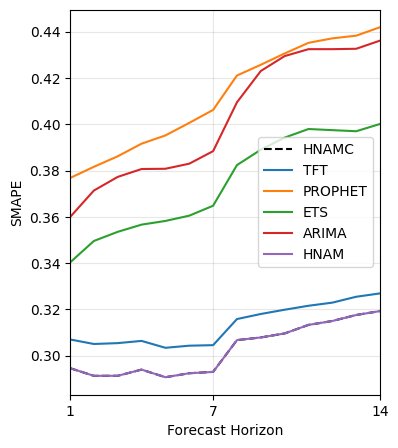

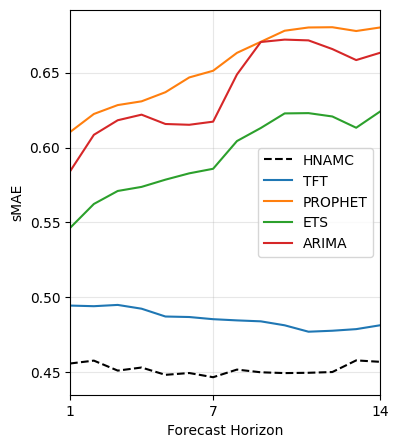

In [13]:
g1 = data.groupby(['h','model'])['smape'].mean()
plt.figure(figsize=(4,5))
toplot = g1.unstack()
toplot['hnam'].plot(ax=plt.gca(),label='hnamc',color='black',linestyle='--')
for model in models:
    if model != 'hnamc':
        toplot[model].plot(ax=plt.gca(),label=model)

plt.xticks([1,7,14])
plt.ylabel('SMAPE')
plt.xlabel('Forecast Horizon')
# Change legend to make everything upper
plt.grid(alpha=0.3)
plt.xlim(1,14)
l = plt.legend()
labels = [label.get_text().upper() for label in l.get_texts()]
plt.legend(labels=labels)
plt.show()


g1 = data.groupby(['h','model'])['mae_std'].median()
plt.figure(figsize=(4,5))
toplot = g1.unstack()
toplot['hnam'].plot(ax=plt.gca(),label='hnamc',color='black',linestyle='--')
for model in models:
    if model != 'hnam':
        toplot[model].plot(ax=plt.gca(),label=model)
plt.xticks([1,7,14])
plt.ylabel('sMAE')
plt.xlabel('Forecast Horizon')
plt.legend([model.upper() for model in models])
plt.grid(alpha=0.3)
plt.xlim(1,14)
l = plt.legend()
labels = [label.get_text().upper() for label in l.get_texts()]
plt.legend(labels=labels)
plt.show()

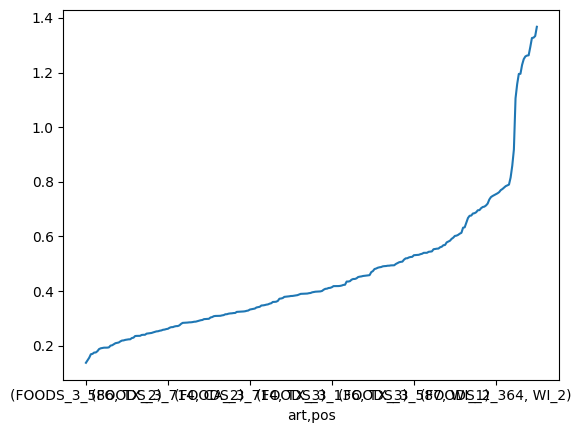

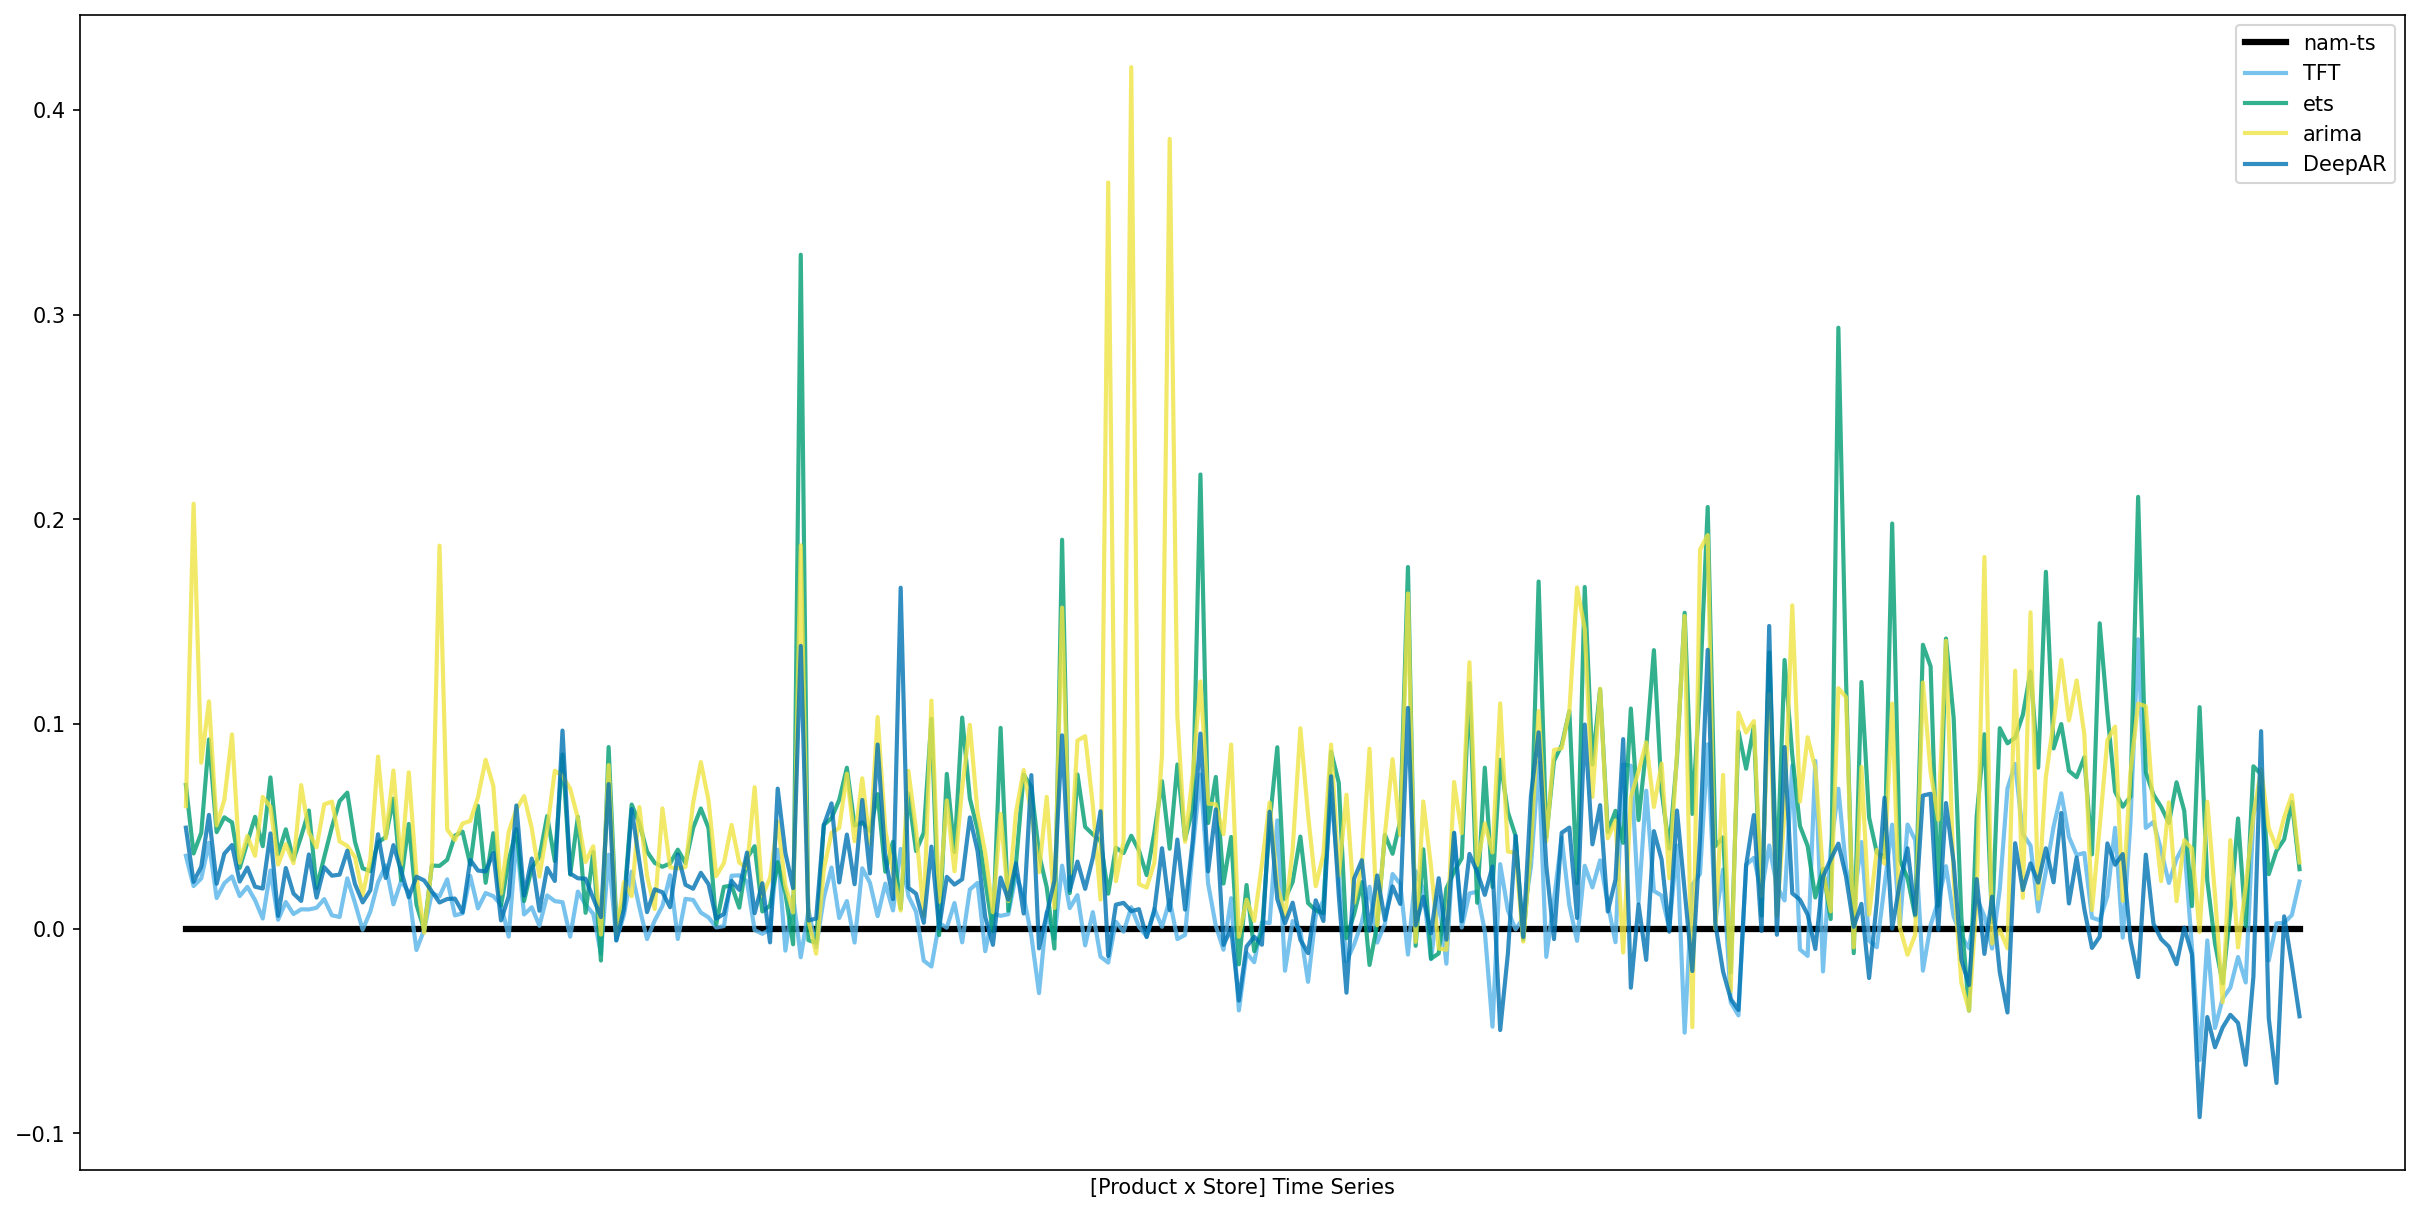

In [ ]:
df_g = data.groupby(['model','art','pos'])['smape'].mean()
aps = df_g['nam-ts'].sort_values().index
df_g['nam-ts'][aps].plot()
plt.show()
df_g = df_g - df_g['nam-ts']
df_g = df_g.swaplevel(0,-1).swaplevel(-1,-2)
plt.figure(figsize=(20,10),dpi=150)
df_g['nam-ts'][aps].plot(label='nam-ts',lw=3,color='black')

colors = ['#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2']
for i,m in enumerate(models):
    if m == 'nam-ts':
        continue
    df_g[m][aps].plot(label=m,alpha=0.8,lw=2,color=colors[i])

plt.xticks([],[])
plt.xlabel('[Product x Store] Time Series')
# plt.yscale('log')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


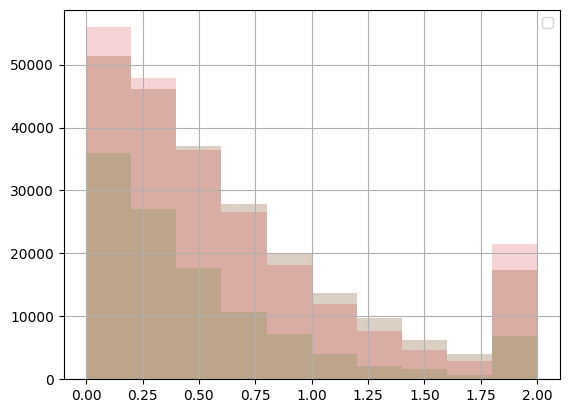

In [ ]:
data.groupby(['model'])['smape'].hist(alpha=0.2)
plt.legend()

In [ ]:
preds_df = data.query('h==7').pivot_table(index='pred_idx',columns=['model','u_id'],values='pred')
actuals_df = data.query('h==7').pivot_table(index='pred_idx',columns=['model','u_id'],values='sales')

bad = data.groupby(['model','u_id'])['smape'].mean().loc['nam-ts'].sort_values().index[0]

<Axes: xlabel='pred_idx'>

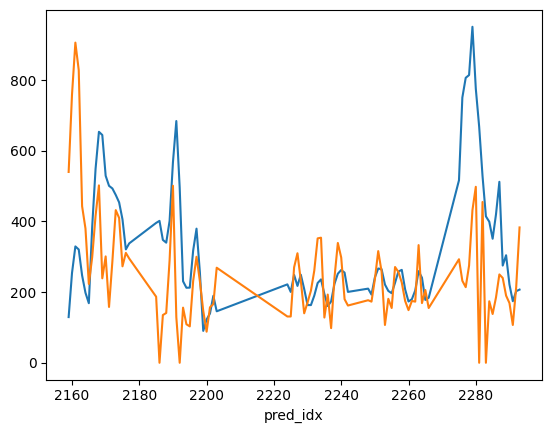

In [ ]:
# preds_df[('nam-ts',bad)].plot()
# preds_df[('prophet',bad)].plot()
preds_df[('ets',bad)].plot()
actuals_df[('nam-ts',bad)].plot()

In [ ]:
data.groupby(['model','u_id'])['smape'].mean().loc['ets'].sort_values()

KeyError: 'ets'